## Image Captioning

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import sys
import os
from PIL import Image


In [2]:

from tensorflow.python.keras import backend as K
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Input, Dense, GRU, Embedding
from tensorflow.python.keras.applications import VGG16
from tensorflow.python.keras.optimizers import RMSprop
from tensorflow.python.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences

In [55]:
import coco

In [56]:
_, filenames_train, captions_train = coco.load_records(train=True)

- Data loaded from cache-file: data/coco/records_train.pkl


In [57]:
num_images_train = len(filenames_train)
num_images_train

118287

In [58]:
_, filenames_val, captions_val = coco.load_records(train=False)

- Data loaded from cache-file: data/coco/records_val.pkl


In [59]:
def load_image(path, size=None):
    img = Image.open(path)
    if not size is None:
        img = img.resize(size=size, resample=Image.LANCZOS)
    img = np.array(img)
    img = img / 255.0

    if (len(img.shape) == 2):
        img = np.repeat(img[:, :, np.newaxis], 3, axis=2)

    return img

In [63]:
import h5py
from tensorflow.python.keras.models import load_model

In [64]:
image_model = load_model('/home/varu/Desktop/Image Captioning Project/data/coco/imgmodel.h5')

In [65]:
image_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [66]:
layer_temp = image_model.get_layer('fc2')

In [67]:
image_model_upd = Model(inputs=image_model.input,
                             outputs=layer_temp.output)

In [68]:
img_size = K.int_shape(image_model.input)[1:3]
img_size

(224, 224)

In [69]:
transfer_values_size = K.int_shape(layer_temp.output)[1]
transfer_values_size

4096

In [70]:
def print_progress(count, max_count):
    pct_complete = count / max_count
    msg = "\r- Progress: {0:.1%}".format(pct_complete)
    sys.stdout.write(msg)
    sys.stdout.flush()

In [71]:
def process_images(data_dir, filenames, batch_size=32):
    num_images = len(filenames)
    shape = (batch_size,) + img_size + (3,)
    image_batch = np.zeros(shape=shape, dtype=np.float16)
 
    shape = (num_images, transfer_values_size)
    transfer_values = np.zeros(shape=shape, dtype=np.float16)
    start_index = 0
    while start_index < num_images:
        print_progress(count=start_index, max_count=num_images)
        end_index = start_index + batch_size
        if end_index > num_images:
            end_index = num_images
        current_batch_size = end_index - start_index
        for i, filename in enumerate(filenames[start_index:end_index]):
            path = os.path.join(data_dir, filename)

            img = load_image(path, size=img_size)
            image_batch[i] = img

       
        transfer_values_batch = \
            image_model_upd.predict(image_batch[0:current_batch_size])
        transfer_values[start_index:end_index] = \
            transfer_values_batch[0:current_batch_size]
        start_index = end_index
    print()
    return transfer_values

In [72]:
def process_images_train():
    print("Processing {0} images in training-set ...".format(len(filenames_train)))
    cache_path = os.path.join(coco.data_dir,
                              "transfer_values_train.pkl")


    transfer_values = cache(cache_path=cache_path,
                            fn=process_images,
                            data_dir=coco.train_dir,
                            filenames=filenames_train)

    return transfer_values

In [73]:
def process_images_val():
    print("Processing {0} images in validation-set ...".format(len(filenames_val)))
    cache_path = os.path.join(coco.data_dir, "transfer_values_val.pkl")

    transfer_values = cache(cache_path=cache_path,
                            fn=process_images,
                            data_dir=coco.val_dir,
                            filenames=filenames_val)

    return transfer_values

In [74]:
%%time
transfer_values_train = process_images_train()
print("dtype:", transfer_values_train.dtype)
print("shape:", transfer_values_train.shape)

Processing 118287 images in training-set ...
- Data loaded from cache-file: data/coco/transfer_values_train.pkl
dtype: float16
shape: (118287, 4096)
CPU times: user 164 ms, sys: 704 ms, total: 868 ms
Wall time: 1.02 s


In [75]:
%%time
transfer_values_val = process_images_val()
print("dtype:", transfer_values_val.dtype)
print("shape:", transfer_values_val.shape)

Processing 5000 images in validation-set ...
- Data loaded from cache-file: data/coco/transfer_values_val.pkl
dtype: float16
shape: (5000, 4096)
CPU times: user 23 ms, sys: 41.5 ms, total: 64.4 ms
Wall time: 1.53 s


In [76]:
mark_start = 'ssss '
mark_end = ' eeee'

In [77]:
def mark_captions(captions_listlist):
    captions_marked = [[mark_start + caption + mark_end
                        for caption in captions_list]
                        for captions_list in captions_listlist]
    
    return captions_marked

In [78]:
captions_train_marked = mark_captions(captions_train)
captions_train_marked[0]

['ssss Closeup of bins of food that include broccoli and bread. eeee',
 'ssss A meal is presented in brightly colored plastic trays. eeee',
 'ssss there are containers filled with different kinds of foods eeee',
 'ssss Colorful dishes holding meat, vegetables, fruit, and bread. eeee',
 'ssss A bunch of trays that have different food. eeee']

In [80]:
def flatten(captions_listlist):
    captions_list = [caption
                     for captions_list in captions_listlist
                     for caption in captions_list]
    
    return captions_list

In [81]:
captions_train_flat = flatten(captions_train_marked)

In [82]:
num_words = 10000

In [83]:
class TokenizerWrap(Tokenizer):
    
    
    def __init__(self, texts, num_words=None):
      
        Tokenizer.__init__(self, num_words=num_words)

        self.fit_on_texts(texts)

        self.index_to_word = dict(zip(self.word_index.values(),
                                      self.word_index.keys()))

    def token_to_word(self, token):

        word = " " if token == 0 else self.index_to_word[token]
        return word 

    def tokens_to_string(self, tokens):
        words = [self.index_to_word[token]
                 for token in tokens
                 if token != 0]
        

        text = " ".join(words)

        return text
    
    def captions_to_tokens(self, captions_listlist):
        tokens = [self.texts_to_sequences(captions_list)
                  for captions_list in captions_listlist]
        
        return tokens

In [84]:
%%time
tokenizer = TokenizerWrap(texts=captions_train_flat,
                          num_words=num_words)

CPU times: user 7.58 s, sys: 0 ns, total: 7.58 s
Wall time: 7.58 s


In [5]:
token_start = tokenizer.word_index[mark_start.strip()]

In [86]:
token_end = tokenizer.word_index[mark_end.strip()]
token_end

3

In [87]:
%%time
tokens_train = tokenizer.captions_to_tokens(captions_train_marked)

CPU times: user 6.91 s, sys: 45.6 ms, total: 6.96 s
Wall time: 6.96 s


In [88]:
tokens_train[0]

[[2, 841, 5, 2864, 5, 61, 26, 1984, 238, 9, 433, 3],
 [2, 1, 429, 10, 3310, 7, 1025, 390, 501, 1110, 3],
 [2, 63, 19, 993, 143, 8, 190, 958, 5, 743, 3],
 [2, 299, 725, 25, 343, 208, 264, 9, 433, 3],
 [2, 1, 170, 5, 1110, 26, 446, 190, 61, 3]]

In [89]:
captions_train_marked[0]

['ssss Closeup of bins of food that include broccoli and bread. eeee',
 'ssss A meal is presented in brightly colored plastic trays. eeee',
 'ssss there are containers filled with different kinds of foods eeee',
 'ssss Colorful dishes holding meat, vegetables, fruit, and bread. eeee',
 'ssss A bunch of trays that have different food. eeee']

In [90]:
def get_random_caption_tokens(idx):
   
    result = []

    for i in idx:
        j = np.random.choice(len(tokens_train[i]))
        tokens = tokens_train[i][j]
        result.append(tokens)

    return result

In [91]:
def batch_generator(batch_size):
   
    while True:
        idx = np.random.randint(num_images_train,
                                size=batch_size)
        transfer_values = transfer_values_train[idx]
        tokens = get_random_caption_tokens(idx)
        num_tokens = [len(t) for t in tokens]
        max_tokens = np.max(num_tokens)

        tokens_padded = pad_sequences(tokens,
                                      maxlen=max_tokens,
                                      padding='post',
                                      truncating='post')
        
        decoder_input_data = tokens_padded[:, 0:-1]
        decoder_output_data = tokens_padded[:, 1:]

        x_data = \
        {
            'decoder_input': decoder_input_data,
            'transfer_values_input': transfer_values
        }

        y_data = \
        {
            'decoder_output': decoder_output_data
        }
        
        yield (x_data, y_data)

In [92]:
batch_size = 512

In [93]:
generator = batch_generator(batch_size=batch_size)

In [95]:
batch = next(generator)
batch_x = batch[0]
batch_y = batch[1]

In [96]:
batch_x['transfer_values_input'][0]

array([0.    , 0.    , 1.282 , ..., 0.    , 0.    , 0.7603], dtype=float16)

In [97]:
batch_x['decoder_input'][0]

array([   2,    1,   57,    8,    1,  117,    9,    1,   80,   38,    1,
       2460,    3,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
      dtype=int32)

In [98]:
batch_y['decoder_output'][0]

array([   1,   57,    8,    1,  117,    9,    1,   80,   38,    1, 2460,
          3,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
      dtype=int32)

In [99]:
num_captions_train = [len(captions) for captions in captions_train]

In [100]:
total_num_captions_train = np.sum(num_captions_train)

In [101]:
steps_per_epoch = int(total_num_captions_train / batch_size)
steps_per_epoch

1155

In [102]:
state_size = 512

In [103]:
embedding_size = 128

In [104]:
transfer_values_input = Input(shape=(transfer_values_size,),
                              name='transfer_values_input')

In [105]:
decoder_transfer_map = Dense(state_size,
                             activation='tanh',
                             name='decoder_transfer_map')

In [106]:
decoder_input = Input(shape=(None, ), name='decoder_input')

In [107]:
decoder_embedding = Embedding(input_dim=num_words,
                              output_dim=embedding_size,
                              name='decoder_embedding')

In [108]:
decoder_gru1 = GRU(state_size, name='decoder_gru1',
                   return_sequences=True)
decoder_gru2 = GRU(state_size, name='decoder_gru2',
                   return_sequences=True)
decoder_gru3 = GRU(state_size, name='decoder_gru3',
                   return_sequences=True)

In [109]:
decoder_dense = Dense(num_words,
                      activation='linear',
                      name='decoder_output')

In [110]:
def connect_decoder(transfer_values):
    initial_state = decoder_transfer_map(transfer_values)
    net = decoder_input
    net = decoder_embedding(net)
    
    net = decoder_gru1(net, initial_state=initial_state)
    net = decoder_gru2(net, initial_state=initial_state)
    net = decoder_gru3(net, initial_state=initial_state)
    decoder_output = decoder_dense(net)
    
    return decoder_output

In [111]:
decoder_output = connect_decoder(transfer_values=transfer_values_input)

decoder_model = Model(inputs=[transfer_values_input, decoder_input],
                      outputs=[decoder_output])

In [190]:
def sparse_cross_entropy(y_true, y_pred):
    loss_mean= tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_true,
                                                          logits=y_pred))
    return loss_mean

In [191]:
optimizer = RMSprop(lr=1e-3)

In [192]:
decoder_target = tf.placeholder(dtype='int32', shape=(None, None))

In [193]:
decoder_model.compile(optimizer=optimizer,
                      loss=sparse_cross_entropy,
                      target_tensors=[decoder_target])

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [194]:
path_checkpoint = '22_checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      verbose=1,
                                      save_weights_only=True)

In [195]:
callback_tensorboard = TensorBoard(log_dir='./22_logs/',
                                   histogram_freq=0,
                                   write_graph=False)

In [196]:
callbacks = [callback_checkpoint, callback_tensorboard]

In [197]:
try:
    decoder_model.load_weights(path_checkpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

In [198]:
import h5py
from tensorflow.python.keras.models import load_model


In [199]:


decoder_model = load_model('/home/varu/Desktop/TensorFlow-Tutorials-master/data/coco/caption.h5',custom_objects={'sparse_cross_entropy':sparse_cross_entropy})



In [220]:
'''%%time

decoder_model.fit_generator(generator=generator,
                            steps_per_epoch=steps_per_epoch,
                               epochs=2,
                                callbacks=callbacks)'''


'%%time\n\ndecoder_model.fit_generator(generator=generator,\n                            steps_per_epoch=steps_per_epoch,\n                               epochs=2,\n                                callbacks=callbacks)'

## Generate Captions


In [215]:
def generate_caption(image_path, max_tokens=30):
    image = load_image(image_path, size=img_size)
    
    image_batch = np.expand_dims(image, axis=0)
    transfer_values = image_model_upd
    .predict(image_batch)
    shape = (1, max_tokens)
    decoder_input_data = np.zeros(shape=shape, dtype=np.int)
    token_int = token_start
    output_text = ''
    count_tokens = 0
    while token_int != token_end and count_tokens < max_tokens:
        decoder_input_data[0, count_tokens] = token_int
        x_data = \
        {
            'transfer_values_input': transfer_values,
            'decoder_input': decoder_input_data
        }
        decoder_output = decoder_model.predict(x_data)
        token_onehot = decoder_output[0, count_tokens, :]
        token_int = np.argmax(token_onehot)
        sampled_word = tokenizer.token_to_word(token_int)
        count_tokens += 1
    output_tokens = decoder_input_data[0]

    plt.imshow(image)
    plt.show()
    print("Predicted caption:")
    print(output_text.replace('eeee','.'))
    print()

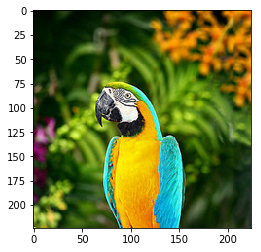

Predicted caption:
 a bird is sitting on a tree limb .



In [216]:
generate_caption("images/parrot_cropped1.jpg")

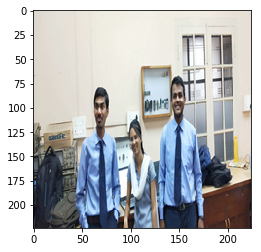

Predicted caption:
 a man and woman are standing in front of a wedding cake eeee



In [210]:
generate_caption("images/IMG20190515102619.jpg")

In [204]:
def generate_caption_coco(idx, train=False):
    if train:
        data_dir = coco.train_dir
        filename = filenames_train[idx]
        captions = captions_train[idx]
    else:
        data_dir = coco.val_dir
        filename = filenames_val[idx]
        captions = captions_val[idx]

    path = os.path.join(data_dir, filename)
    generate_caption(image_path=path)
    print("True captions:")
    for caption in captions:
        print(caption)

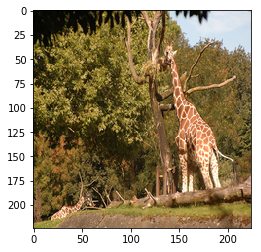

Predicted caption:
 a giraffe standing in the middle of a forest eeee

True captions:
A giraffe eating food from the top of the tree.
A giraffe standing up nearby a tree 
A giraffe mother with its baby in the forest.
Two giraffes standing in a tree filled area.
A giraffe standing next to a forest filled with trees.


In [205]:
generate_caption_coco(idx=1, train=True)

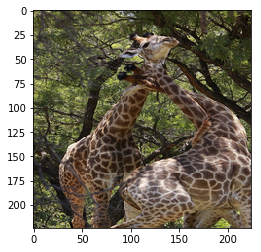

Predicted caption:
 a giraffe standing next to a tree in a forest eeee

True captions:
A couple of giraffe snuggling each other in a forest.
A couple of giraffe standing next to some trees.
Two Zebras seem to be embracing in the wild. 
Two giraffes hang out near trees and nuzzle up to each other.
The two giraffes appear to be hugging each other.


In [206]:
generate_caption_coco(idx=10, train=True)

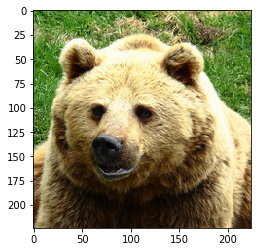

Predicted caption:
 a dog laying on the ground with its tongue out eeee

True captions:
A big burly grizzly bear is show with grass in the background.
The large brown bear has a black nose.
Closeup of a brown bear sitting in a grassy area.
A large bear that is sitting on grass. 
A close up picture of a brown bear's face.


In [207]:
generate_caption_coco(idx=1, train=False)